# Undirected Graph

$
G = (V,E),~ |V|=n \\
W = (w_{ij} \ge 0)_{i,j = 1,...,n} \\
d_i = \sum_j w_{ij} \\
D = diag(d_1,...,d_n). 
$

For a partition $V = S \cup S^c$:

$$ Ncut(S,S^c) = \frac{Vol \partial S}{Vol S}  + \frac{Vol \partial S}{Vol S^c} $$

where:

$
\partial S = \{e \in E ; |e \cap S| = |e \cap S^c| = 1 \} \\
Vol(S) = \sum_{v \in S} d(v), \\
Vol(\partial S) = \sum_{(v_i, v_j) \in \partial S} w_{ij}.
$

Random walk view:

$$
P = D^{-1}W, ~~ Ncut(S,S^c) = P(S|S^c) + P(S^c|S)
$$.

The problem can be solved by relaxing over real values:

$$ f^* = \underset{f \in \mathbb{R}^n}{\operatorname{argmin}} f^t \Delta f,~ f \perp D^{1/2} \cdot 1,~ ||f||^2 = 1. $$
where:
$$ \Delta = I - D^{-1/2} W D^{-1/2} $$
the (normalized) graph Laplacian.

##### REF: U. von Luxberg, "A Tutorial on Spectral Clustering"


# Semi-supervised learning on $G$

$
f^* = \underset{f \in H(V)}{\operatorname{argmin}} \left( \Omega(f) + {\mu} ||f-y||^2
\right) \\
\Omega(f) = <f^t, \Delta f> = \frac{1}{2} \sum_{(v_i,v_j) \in E} w_{ij} \left(\frac{f(v_i)}{\sqrt{d_i}} + \frac{f(v_j)}{\sqrt{d_j}}\right)^2
$

$y$ is a given vector of initial labels, typically $y_i \in {-1,0,1}$.

The solution is given by:
$
f^* = (1-\alpha)(I-\alpha S)^{-1}y,~ \alpha=(1+\mu)^{-1},~ S = I - \Delta. 
$


In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, diags, identity, rand
from math import sqrt
from scipy.sparse.linalg import cg, inv
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Build toy sparse weight matrix W for an undirected graph
row = [0,0,1,2,2,3]
col = [1,2,2,3,4,4]
data = [1,3,2,2,2,2]
n = max(row+col)+1
W = csr_matrix((data, (row,col)), shape=(n,n))
## labels for SSL
y = [0,1,1,0,-1]


e:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


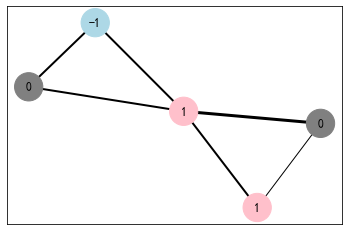

In [3]:
## from csr matrix to networkx graph
G = nx.from_numpy_matrix(W.todense())
pos = nx.spring_layout(G)
d = {k:v for k,v in enumerate(y)}
nx.draw_networkx(G, pos=pos, node_color=['grey','pink','pink','grey','lightblue'],
                width=data, labels=d, node_size=800)

In [4]:
## Input: 
##   W: adjacency -- weighted triangular matrix
##   y: initial (seed) values
## Output:
##   x: solution of regularization problem via CG or (slow) explicit matrix inversion
def undirected(W, y, alpha=0.5, inverse=False):
    ## undirected -- make W symmetric
    W = W+W.transpose()
    ## build D^{-1/2}, diagonal
    d = np.array(W.sum(axis=0))[0]
    d = [[1/sqrt(d[i]) for i in range(d.shape[0])]]
    D = diags(d, offsets=[0])
    ## Smothness matrix (here for undirected graph):
    ## S = D^{1/2} * W * D^{-1/2}
    S = D * W * D
    ## M = I - alpha*S
    n = W.shape[0]
    I = identity(n)
    M = I - alpha*S
    if(inverse):
        ## Inverse matrix
        Minv = inv(M)
        x = Minv * y    
    else:
        ## Conj. gradient
        x = cg(M,y)[0]       
    return(x)


e:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


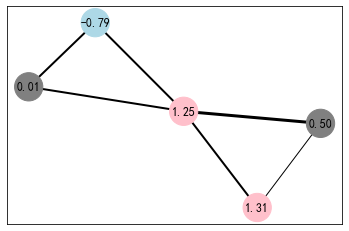

In [5]:
z = undirected(W,y)
d = {k:'%.2f'%v for k,v in enumerate(z)}
nx.draw_networkx(G, pos=pos, node_color=['grey','pink','pink','grey','lightblue'],
                width=data, labels=d, node_size=800)

# Other smoothess models

The transductive learning framework can be used to define several smoothing functions
on graphs such as:

* co-linkage (indirect relations -- shared neighbours)
* hybrid (undirected and co-linkage: consider both direct and indirect relations)

All models can also be defined for directed graphs.

Below, we look at the same toy graph; the effect of the 'co-linkage' 
model can be seen on the gray nodes.


In [6]:
## undirected TL on a Graph
def colink(W, y, alpha=0.5):
    W = W+W.transpose() ## undirected case
    ## build D^{-1/2}, diagonal
    d = np.array(W.sum(axis=0))[0]
    d = [[1/sqrt(d[i]) for i in range(d.shape[0])]]
    D = diags(d, offsets=[0])
    ## Smothness matrix (here for undirected graph):
    ## T = D^{1/2} * W * D^{-1/2}
    T = D * W * D
    S = T.transpose() * T
    ## M = I - alpha*S
    n = W.shape[0]
    I = identity(n)
    M = I - alpha*S
    ## Conjugate gradient
    x = cg(M,y)
    return(x[0])

## undirected TL on a Graph
def hybrid(W, y, alpha=0.5, gamma = 0.5):
    W = W+W.transpose() ## undirected case
    ## build D^{-1/2}, diagonal
    d = np.array(W.sum(axis=0))[0]
    d = [[1/sqrt(d[i]) for i in range(d.shape[0])]]
    D = diags(d, offsets=[0])
    ## Smothness matrix (here for undirected graph):
    ## T = D^{1/2} * W * D^{-1/2}
    T = D * W * D
    S = gamma * T + (1-gamma)*T.transpose() * T
    ## M = I - alpha*S
    n = W.shape[0]
    I = identity(n)
    M = I - alpha*S
    ## Conjugate gradient
    x = cg(M,y)
    return(x[0])


e:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


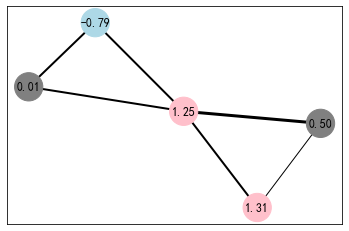

In [7]:
z = undirected(W, y)
d = {k:'%.2f'%v for k,v in enumerate(z)}
nx.draw_networkx(G, pos=pos, node_color=['grey','pink','pink','grey','lightblue'],
                width=[1,3,2,2,2,2], labels=d, node_size=800)


e:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


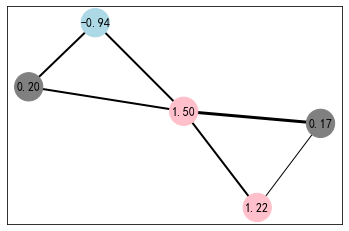

In [8]:
z = colink(W, y)
d = {k:'%.2f'%v for k,v in enumerate(z)}
nx.draw_networkx(G, pos=pos, node_color=['grey','pink','pink','grey','lightblue'],
                width=[1,3,2,2,2,2], labels=d, node_size=800)


e:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


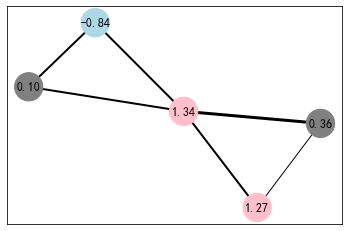

In [9]:
z = hybrid(W, y)
d = {k:'%.2f'%v for k,v in enumerate(z)}
nx.draw_networkx(G, pos=pos, node_color=['grey','pink','pink','grey','lightblue'],
                width=[1,3,2,2,2,2], labels=d, node_size=800)


## Random graph example

* generate random graph and seeds
* look for high scoring non-seed vertices

In [10]:
g = ig.Graph.Erdos_Renyi(n=100,m=500)
A = csr_matrix(np.array(g.get_adjacency().data))
## label probability and vertex color
y = np.random.choice(2,100,p=[.9,.1])
g.vs['seed'] = y
cl = ['black','red']
for v in g.vs:
    v['color'] = cl[v['seed']]
nlv = sum(y)
print(nlv,'labelled vertices')

10 labelled vertices


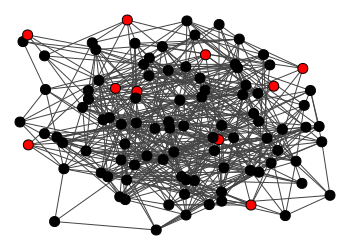

In [11]:
## Plot
g.vs['size'] = 10
ly = g.layout("kk")  ## kamada-kawai; usually nice
ig.plot(g, layout=ly, bbox=(0,0,350,250))


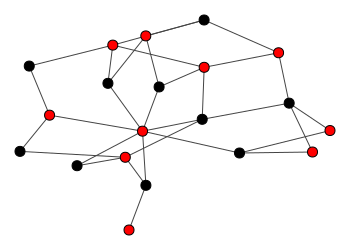

In [12]:
## now look at top-scoring vertices
TOP = 2*nlv
tl = undirected(A,y)
s = sorted(range(len(tl)), key=lambda k: -tl[k])
sg = g.subgraph(s[:TOP])
## plot
ly = sg.layout("kk")  ## kamada-kawai; usually nice
ig.plot(sg, layout=ly, bbox=(0,0,350,250))


In [13]:
## Now consider 2 initial labels: -1 (blue) and +1 (red)
g = ig.Graph.Erdos_Renyi(n=100,m=500)
A = csr_matrix(np.array(g.get_adjacency().data))
## label probability and vertex color
y = np.random.choice(3,100,p=[.05,.9,.05])
g.vs['seed'] = y
cl = ['blue','black','red']
for v in g.vs:
    v['color'] = cl[v['seed']]
nlv = sum(np.abs(y-1))
print(nlv,'labelled vertices')

14 labelled vertices


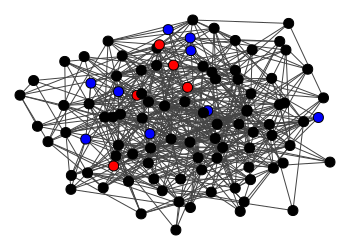

In [14]:
## Plot
g.vs['size'] = 10
ly = g.layout("kk")  ## kamada-kawai; usually nice
ig.plot(g, layout=ly, bbox=(0,0,350,250))


In [15]:
## now look at top/bottom-scoring vertices
## color them in pink/lightblue
N = nlv
tl = undirected(A,y-1)
s = sorted(range(len(tl)), key=lambda k: -tl[k])
for i in s[:N]:
    if g.vs[i]['color'] == 'black':
        g.vs[i]['color'] = 'pink'
s = sorted(range(len(tl)), key=lambda k: tl[k])
for i in s[:N]:
    if g.vs[i]['color'] == 'black':
        g.vs[i]['color'] = 'lightblue'


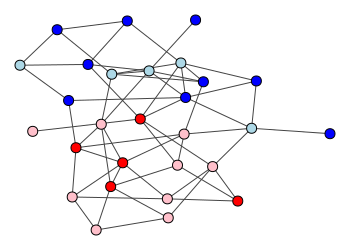

In [16]:
## plot non-black nodes
v = [i for i in range(g.vcount()) if g.vs[i]['color']!='black']
sg = g.subgraph(v)
ly = sg.layout("kk")  ## kamada-kawai; usually nice
ig.plot(sg, layout=ly, bbox=(0,0,350,250))


# Hypergraph

For an undirected hypergraph, we define:

* $E$: set of subsets $e \subset V,~ |e| \ge 2$
* $w(e)>0$: hyperedge weight
* $d(v) = \sum_{e; v \in e} w(e)$
* $H: |E| \times |V|$ s.t. $h(e,v)=1$ iff $v \in e$
* $W = diag(w(e)),$
* $D_v = diag(d(v)),$
* $D_e = diag(|e|).$


The Ncut problem can be generalized to hypergraphs. For a partition
$V = S \cup S^c$, let:

$
\partial S = \{ e \in E ; e \cap S \ne \emptyset,~ e \cap S^c \ne \emptyset\},\\
Vol S = \sum_{v \in S} d(v), \\
Vol \partial S = \sum_{e \in \partial S} w(e) \frac{|e \cap S| \cdot |e \cap S^c|}{|e|}
$

For the last expression, if $e$ is mapped to its 2-section, the numerator is the number of 'edges' that would be cut.

The Ncut problem $\underset{S \subset V}{\operatorname{argmin}} \left(\frac{Vol \partial S}{Vol S} + \frac{Vol \partial S}{Vol S^c} \right)$ can again
be illustrated via a random walk with

$$
p(u,v) = \sum_{e \in E} \frac{w(e) h(u,e)}{d(u)} \frac{h(v,e)}{|e|}
$$

with stationary distribution $\pi(v) = \frac{d(v)}{Vol V}$.  
We get the following results:

$
\frac{Vol S}{Vol V} = \sum_{v \in S} \pi(v), \\
\frac{Vol \partial S}{Vol V} = \sum_{u \in S} \sum_{v \in S^c} \pi(u) p(u,v).
$

solving the relaxed problem yields the same form as with graph, but with $\Delta = I - D_v^{-1/2} H^T W D_e^{-1} H D_v^{-1/2}$.

When all $|e|=2$, we get $\Delta = \frac{1}{2} (I-D_v^{-1/2} W D_v^{-1/2})$, half of the graph Lapacian, so $\Delta$
can be defined as the "hypergraph Laplacian". 

##### REF: Zhou, Huang and Scholkopf.
 

# Semi-supervised learning on hypergraph

We define the same problem as with graphs:

$$ f^* = \underset{f \in H(V)}{\operatorname{argmin}} (\Omega(f) + \mu ||f-y||^2) $$

where:

$$
\Omega(f) = \langle f,\triangle f \rangle =
\frac{1}{2} \sum_{e \in E} \frac{1}{\delta(e)}
\sum_{(u,v) \in e} w(e) \left( \frac{f(u)}{\sqrt{d(u)}} - 
\frac{f(v)}{\sqrt{d(v)}} \right)^2
$$

The solution to the above problem is given by
$$ f^* = (1-\alpha)(I-\alpha S)^{-1}y,~ \alpha=(1+\mu)^{-1},~ S = I - \Delta. $$

This can be solved efficiently via a conjugate gradient method, for example.



# From hypergraph to graph via random walk

Let $G = (V,E)$ be an undirected hypergraph.
The random walk on hypergraphs described in the previous section
amounts steps of the following form:

* from vertex $u$, pick an hyperedge $e$ at random for which $u \in e$
* pick a vertex $v \in e$ at random and jump to $v$.

We can view G as a graph with a weighted adjacency matrix $\tilde{A} = (a_{ij})$
where:

$a_{ij} = \sum_{e;(v_i,v_j) \in e} \frac{w(e)}{|e|},~ a_{ii} = \sum_{e;v_i \in e} \frac{w(e)}{|e|}$

with row sum

$a_{i.} = \sum_{e; v_i \in e} w(e) = \sum_{e \in E} w(e) h(e,v_i) = d(v_i)$.

If all $|e|=2$, we get $a_{ii} = \sum_{e; v_i \in e} w(e)/2 = d_i/2$   
and for $e = (v_i,v_j)$ we get $a_{ij} = w(e)/2$, therefore

$$
\tilde{A} = \frac{1}{2}(D_v + A)
$$

where $A$ is the (weighted) adjacency matrix of the graph representation of this hypergraph, for which all $|e|=2$.

For example, the solution to the transductive learning problem will differ if G is seen as a graph or an hypergraph.




In [17]:
## 1 list per hyperedge e
e = [[0,1],[0,2],[1,2],[2,3],[2,4],[3,4]]
w = [1,3,2,2,2,2]
m = len(e)
y = [0,1,1,0,-1]

col = [x for sub in e for x in sub]
n = max(col)+1
row = [[i]*len(e[i]) for i in range(len(e))]
row = [x for sub in row for x in sub] ## 1-step?
data = [1]*len(col)
H = csr_matrix((data, (row,col)), shape=(m,n))
W = diags([w], offsets=[0])


In [18]:
def hypergraph(H, W, y, alpha=0.5, adjusted=False):
    ## Vertex degrees diagonal matrix Dv^{-1/2}
    X = W * H
    d = np.array(X.sum(axis=0))[0]
    n = len(d)
    d = [1/sqrt(d[i]) for i in range(len(d))]
    Dv = diags([d], offsets=[0])
    ## hyperedge 'degrees' (cardinality) matrix De^{-1}
    if adjusted:
        d = [1/(len(x)-1) for x in e]
    else: 
        d = [1/len(x) for x in e]
    De = diags([d], offsets=[0])
    I = identity(n)
    ## Smothness matrix (here for undirected hypergraph):
    ## S = Dv^{1/2} * H^t * W * De^{-1} * H * Dv^{-1/2}
    S = Dv * H.transpose() * W * De * H * Dv
    if adjusted:
        S = S - Dv * diags(d * W * H) * Dv
    ## M = I - alpha*S
    M = I - alpha*S
    ## solve regularized problem via conjugate gradient
    x = cg(M,y)
    return(x[0])


e:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


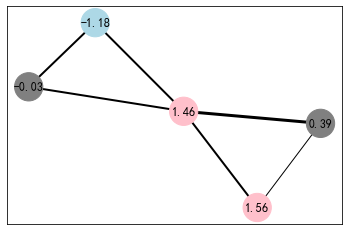

In [19]:
z=hypergraph(H, W, y)
d = {k:'%.2f'%v for k,v in enumerate(z)}
nx.draw_networkx(G, pos=pos, node_color=['grey','pink','pink','grey','lightblue'],
                width=[1,3,2,2,2,2], labels=d, node_size=800)

# Another random walk

We define a new random walk as follows:

* from vertex $u$, pick an hyperedge $e$ at random for which $u \in e$
* pick a vertex $v \in e,~ v \ne u$ at random and jump to $v$.

We can view G as a graph with a weighted adjacency matrix $\tilde{A} = (a_{ij})$
where:

$a_{ij} = \sum_{e;(v_i,v_j) \in e} \frac{w(e)}{|e|-1},~ a_{ii} = 0$

with row sum

$a_{i.} = \sum_{e; v_i \in e} w(e) = d(v_i)$.

We can write in matrix form:

$\tilde{A} = H^T W \tilde{D}_e^{-1} H - D_v$

with $\tilde{D}_e$ the diagonal matrix with entries $\frac{1}{|e|-1}$. 

In this case, the "adjusted hypergraph Laplacian" takes the following form:

$\Delta = I - S$ with $S = D_v^{-1/2} \tilde{A} D_v^{-1/2} - I$

If all $|e|=2$, for $e = (v_i,v_j)$ we get $a_{ij} = w(e)$, therefore
$\tilde{A} = A$ where $A$ is the (weighted) adjacency matrix of the graph representation of this hypergraph.


e:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


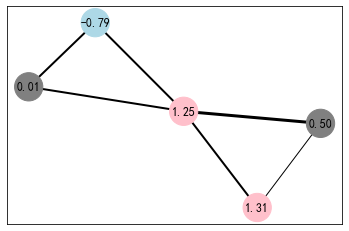

In [20]:
z=hypergraph(H, W, y, adjusted=True)
d = {k:'%.2f'%v for k,v in enumerate(z)}
nx.draw_networkx(G, pos=pos, node_color=['grey','pink','pink','grey','lightblue'],
                width=[1,3,2,2,2,2], labels=d, node_size=800)

## A (non-graph) hypergraph

In [21]:
e = [[0,1],[0,2],[1,2],[2,3,4]]
w = [1,3,2,2]
m = len(e)
y = [0,1,1,0,-1]

col = [x for sub in e for x in sub]
n = max(col)+1
row = [[i]*len(e[i]) for i in range(len(e))]
row = [x for sub in row for x in sub] ## 1-step?
data = [1]*len(col)
H = csr_matrix((data, (row,col)), shape=(m,n))
W = diags([w], offsets=[0])


e:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


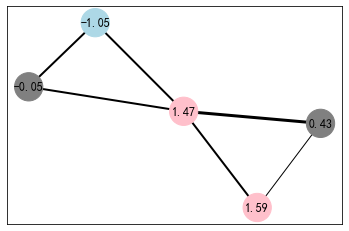

In [22]:
## un-adjusted Laplacian
z = hypergraph(H, W, y, alpha = 0.5, adjusted=False)
d = {k:'%.2f'%v for k,v in enumerate(z)}
nx.draw_networkx(G, pos=pos, node_color=['grey','pink','pink','grey','lightblue'],
                width=[1,3,2,2,2,2], labels=d, node_size=800)

### We apply the adjusted hypergraph Laplacian

### ... and we show equivalence with a simple graph model. 

e:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


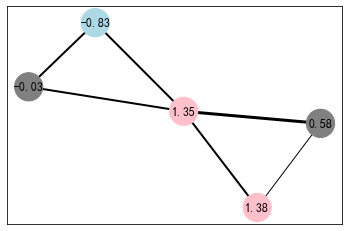

In [23]:
z = hypergraph(H, W, y, adjusted=True)
d = {k:'%.2f'%v for k,v in enumerate(z)}
nx.draw_networkx(G, pos=pos, node_color=['grey','pink','pink','grey','lightblue'],
                width=[1,3,2,2,2,2], labels=d, node_size=800)

In [24]:
## Build toy parse weight matrix W for an undirected graph
## those would be read from file likely matrix market format
row = [0,0,1,2,2,3]
col = [1,2,2,3,4,4]
data = [1,3,2,1,1,1] ## adjusted "random walk" parameters with (1/(|e|-1))
n = max(row+col)+1
W = csr_matrix((data, (row,col)), shape=(n,n))
## labels for SSL, also read from file
y = [0,1,1,0,-1]


e:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


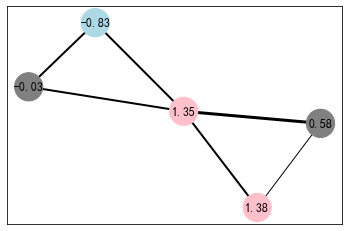

In [25]:
z = undirected(W, y)
d = {k:'%.2f'%v for k,v in enumerate(z)}
nx.draw_networkx(G, pos=pos, node_color=['grey','pink','pink','grey','lightblue'],
                width=[1,3,2,2,2,2], labels=d, node_size=800)
